In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.1


/var/folders/fr/z238tpm931s466144gcdpdj40000gn/T/ipykernel_26819/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [75]:
!pip install scperturb --upgrade

In [76]:
from scperturb import *

In [2]:
import sys
sys.path.append("..")
from src.scperturb import *

# Prepare the data

In [5]:
!wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad

--2023-02-14 19:06:27--  https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33600780 (32M) [application/octet-stream]
Saving to: ‘DatlingerBock2021.h5ad’

DatlingerBock2021.h 100%[===================>]  32,04M  5,85MB/s    in 8,1s    

2023-02-14 19:06:36 (3,97 MB/s) - ‘DatlingerBock2021.h5ad’ saved [33600780/33600780]



In [3]:
adata = sc.read('DatlingerBock2021.h5ad')
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [4]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# E-distance

In [5]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean')

100%|██████████| 41/41 [00:01<00:00, 33.65it/s]


In [6]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

perturbation,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,EGR4_2,NFATC1_2,NFATC1_1,RELA_2,NFKB1_1,RELA_1,NFKB2_1,NFAT5_1,NR4A1_2,RUNX2_1
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,2.172756,1.585194,1.440077,3.689245,2.162596,1.180013,1.089366,1.789582,2.220343,...,1.558446,4.794493,1.381361,0.981288,1.360305,2.614598,0.939371,1.357775,0.881510,1.069860
LAT_2,2.172756,0.000000,1.101750,1.637443,1.378975,0.920937,0.981621,2.261269,0.997213,0.802380,...,2.693458,9.011314,3.993039,2.368455,1.847189,1.108904,1.593318,1.875898,1.731976,1.942660
LCK_2,1.585194,1.101750,0.000000,1.236524,2.087724,1.259033,0.836091,1.642532,0.898775,1.257119,...,1.878790,7.041508,2.836727,1.466042,1.628844,1.979113,1.053297,1.729022,1.115263,1.314329
JUND_2,1.440077,1.637443,1.236524,0.000000,2.247459,1.426152,1.058618,1.273190,1.199590,1.472697,...,1.773139,6.787367,2.584900,1.569521,1.177936,1.925785,1.177522,1.237373,1.140638,1.001204
ZAP70_2,3.689245,1.378975,2.087724,2.247459,0.000000,1.997524,1.816651,3.534980,1.850800,1.584695,...,4.837238,12.841715,6.296509,4.173634,2.993655,1.585855,2.813415,3.017723,3.035914,3.032598


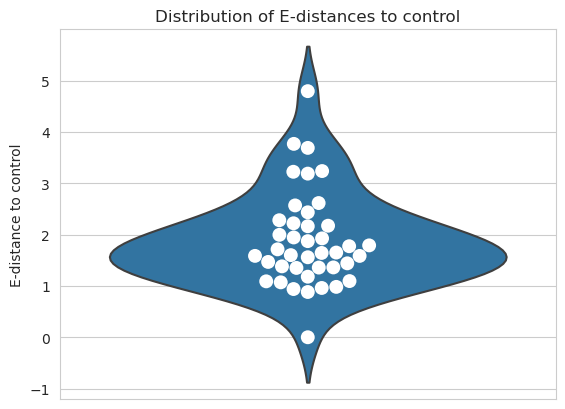

In [7]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

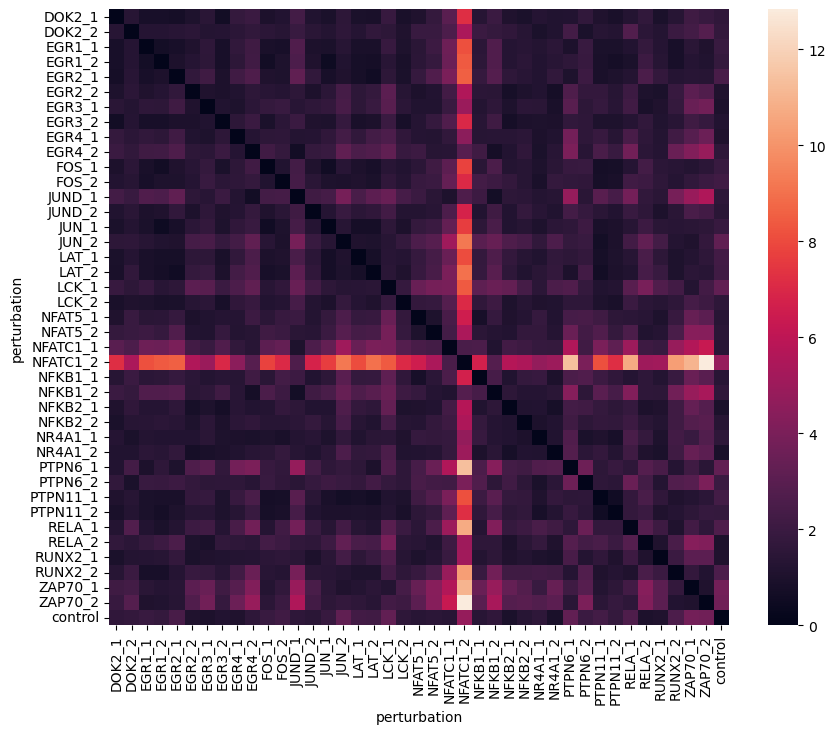

In [8]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [10]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=1000)

100%|██████████| 1000/1000 [00:08<00:00, 121.82it/s]


In [11]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,1.649977,0.084,False,0.827054,False
DOK2_2,1.712826,0.073,False,0.796448,False
EGR1_1,1.926120,0.041,True,0.634782,False
EGR1_2,1.773343,0.053,False,0.698214,False
EGR2_1,2.434011,0.003,True,0.091667,False


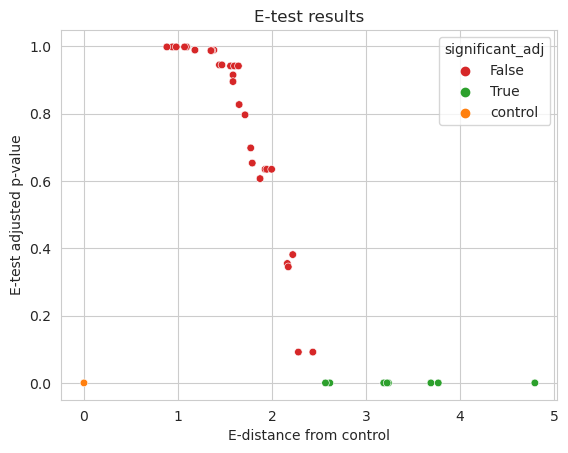

In [12]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

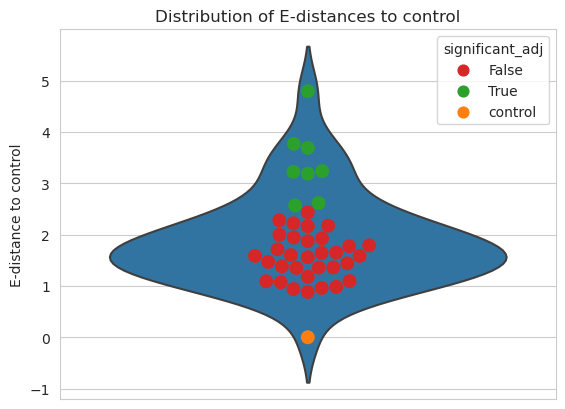

In [13]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()